1. Creat training and testing data

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
from tqdm import tqdm
from random import shuffle

TRAIN_DIR = 'C:\\Kaggle_data\\Dog_vs_Cat\\train\\train'
TEST_DIR = 'C:\\Kaggle_data\\Dog_vs_Cat\\test1\\test1'
IMG_SIZE = 100
TRAIN_DATA_NAME = 'train_data_imgsize{}.npy'.format(IMG_SIZE)
TEST_DATA_NAME = 'test_data_imgsize{}.npy'.format(IMG_SIZE)
LR = 1e-3
OPTIMIZER = 'adam'
MODEL_NAME = 'dogvscats-{}-{}-{}.model'.format(LR,OPTIMIZER,'dropout-0.5-filter-5convlayer')

def label_img(img):
    if img.split('.')[0] == 'cat':
        return [0,1]
    else:
        return [1,0]

def createTrainData():
    imgs = os.listdir(TRAIN_DIR)
    train_data = []
    for img in tqdm(imgs):
        label = label_img(img)
        img = cv2.imread(os.path.join(TRAIN_DIR, img), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        train_data.append([np.array(img),np.array(label)])
    shuffle(train_data)
    np.save(TRAIN_DATA_NAME, train_data)
    return train_data
    
def createTestData():
    imgs = os.listdir(TEST_DIR)
    test_data = []
    for img in tqdm(imgs):
        img_num = img.split('.')[0]
        img = cv2.imread(os.path.join(TEST_DIR, img), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        test_data.append([np.array(img),img_num])
    np.save(TEST_DATA_NAME, test_data)
    return test_data


In [2]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

train_data = np.load(TRAIN_DATA_NAME)
X = np.array([i[0] for i in train_data]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train_data]

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1])

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)


convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.5)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer=OPTIMIZER, learning_rate=LR, loss='categorical_crossentropy')

model = tflearn.DNN(convnet, tensorboard_dir='log')

if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')
else:                     
    model.fit(X, Y, n_epoch=10, validation_set=0.1, shuffle=True,
        snapshot_step=200, show_metric=True, run_id=MODEL_NAME)

    model.save(MODEL_NAME)

Training Step: 3519  | total loss: 0.27339 | time: 271.371s
| Adam | epoch: 010 | loss: 0.27339 - acc: 0.8799 -- iter: 22464/22500
Training Step: 3520  | total loss: 0.28283 | time: 282.531s
| Adam | epoch: 010 | loss: 0.28283 - acc: 0.8762 | val_loss: 0.44972 - val_acc: 0.8076 -- iter: 22500/22500
--
INFO:tensorflow:C:\Users\Pega\Git\CatVSDog\dogvscats-0.001-adam-dropout-0.5-filter-5convlayer.model is not in all_model_checkpoint_paths. Manually adding it.


 3. Visulization

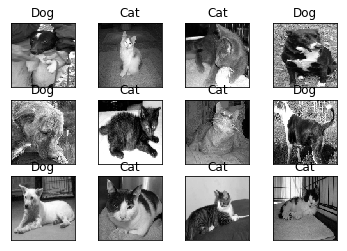

In [5]:
import matplotlib.pyplot as plt

test_data = np.load(TEST_DATA_NAME)

fig = plt.figure()

for num, data in enumerate(test_data[:12]):
    #cat:[1,0]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    model_out = model.predict([data])[0]
    if np.argmax(model_out)==1: str_label='Cat'
    else: str_label = 'Dog'
    y.imshow(orig, cmap='gray')
    #y.imshow(orig)
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

4. generate submission file

In [6]:
test_data = np.load(TEST_DATA_NAME)

with open('submission-file.csv','w') as f:
    f.write('id,label\n')
with open('submission-file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        out=model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,out[0]))

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [01:04<00:00, 192.53it/s]
